In [3]:
!pip install prophet -q
!pip install plotly -q
!pip install seaborn -q

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
import os
os.listdir()


['.config', 'kaggle.json', 'sample_data']

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aprudhviraj","key":"2cba87f902c292584275e44bef74d80d"}'}

In [8]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d patricklford/global-ev-sales-2010-2024

Dataset URL: https://www.kaggle.com/datasets/patricklford/global-ev-sales-2010-2024
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/83.3k [00:00<?, ?B/s]
100% 83.3k/83.3k [00:00<00:00, 234MB/s]


In [10]:
!unzip global-ev-sales-2010-2024.zip

Archive:  global-ev-sales-2010-2024.zip
  inflating: IEA Global EV Data 2024.csv  


In [11]:
os.listdir()

['.config',
 'kaggle (1).json',
 'IEA Global EV Data 2024.csv',
 'global-ev-sales-2010-2024.zip',
 'sample_data']

In [12]:
df = pd.read_csv('IEA Global EV Data 2024.csv')
df.head()


,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
1,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
2,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000


In [13]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12654 entries, 0 to 12653
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      12654 non-null  object 
 1   category    12654 non-null  object 
 2   parameter   12654 non-null  object 
 3   mode        12654 non-null  object 
 4   powertrain  12654 non-null  object 
 5   year        12654 non-null  int64  
 6   unit        12654 non-null  object 
 7   value       12654 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 791.0+ KB


In [14]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
               year         value
count  12654.000000  1.265400e+04
mean    2019.822112  4.273742e+05
std        5.476494  6.860498e+06
min     2010.000000  1.200000e-06
25%     2016.000000  2.000000e+00
50%     2020.000000  1.300000e+02
75%     2022.000000  5.500000e+03
max     2035.000000  4.400000e+08


In [15]:
 #Insight: "Our dataset contains EV sales data from 2010 to 2024 across multiple countries and EV types. It includes numerical and categorical features that will help us analyze and forecast sales trends.

In [16]:
china_ev_sales = df[
    (df['region'] == 'China') &
    (df['parameter'] == 'EV sales') &
    (df['mode'] == 'Cars') &
    (df['powertrain'] == 'BEV') &
    (df['unit'] == 'Vehicles')
].copy()

china_ev_sales = china_ev_sales.sort_values('year')

In [17]:
china_ev_sales.head()

,region,category,parameter,mode,powertrain,year,unit,value
1074,China,Historical,EV sales,Cars,BEV,2010,Vehicles,1100.0
1119,China,Historical,EV sales,Cars,BEV,2011,Vehicles,4800.0
1126,China,Historical,EV sales,Cars,BEV,2012,Vehicles,9600.0
1173,China,Historical,EV sales,Cars,BEV,2013,Vehicles,15000.0
1180,China,Historical,EV sales,Cars,BEV,2014,Vehicles,49000.0


In [18]:
#We focus on Battery Electric Vehicle (BEV) sales for passenger cars in China, which is a leading market in EV adoption.

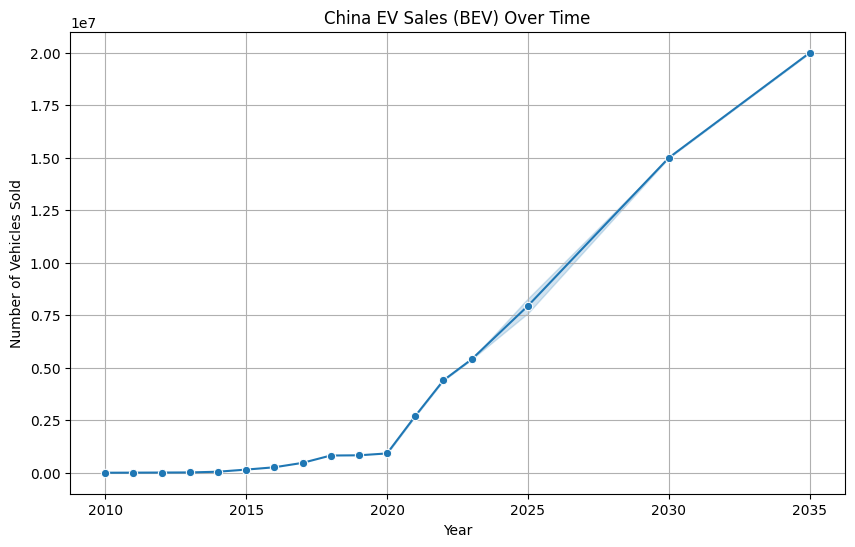

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x='year', y='value', data=china_ev_sales, marker='o')
plt.title('China EV Sales (BEV) Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Vehicles Sold')
plt.grid(True)
plt.show()

In [19]:
#Insight: "This line chart shows the rapid increase in EV sales over the years, indicating a strong adoption trend in China.

In [20]:
china_sales_prophet = china_ev_sales[['year', 'value']].rename(columns={'year':'ds', 'value':'y'})
china_sales_prophet['ds'] = pd.to_datetime(china_sales_prophet['ds'], format='%Y')

In [21]:
china_sales_prophet.head()

,ds,y
1074,2010-01-01,1100.0
1119,2011-01-01,4800.0
1126,2012-01-01,9600.0
1173,2013-01-01,15000.0
1180,2014-01-01,49000.0


In [22]:
model = Prophet(yearly_seasonality=True)
model.fit(china_sales_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw9_wzj0/18k35j6k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw9_wzj0/qugtq29p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23046', 'data', 'file=/tmp/tmplw9_wzj0/18k35j6k.json', 'init=/tmp/tmplw9_wzj0/qugtq29p.json', 'output', 'file=/tmp/tmplw9_wzj0/prophet_modeljk_b0kyw/prophet_model-20250615073802.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:38:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [23]:
future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


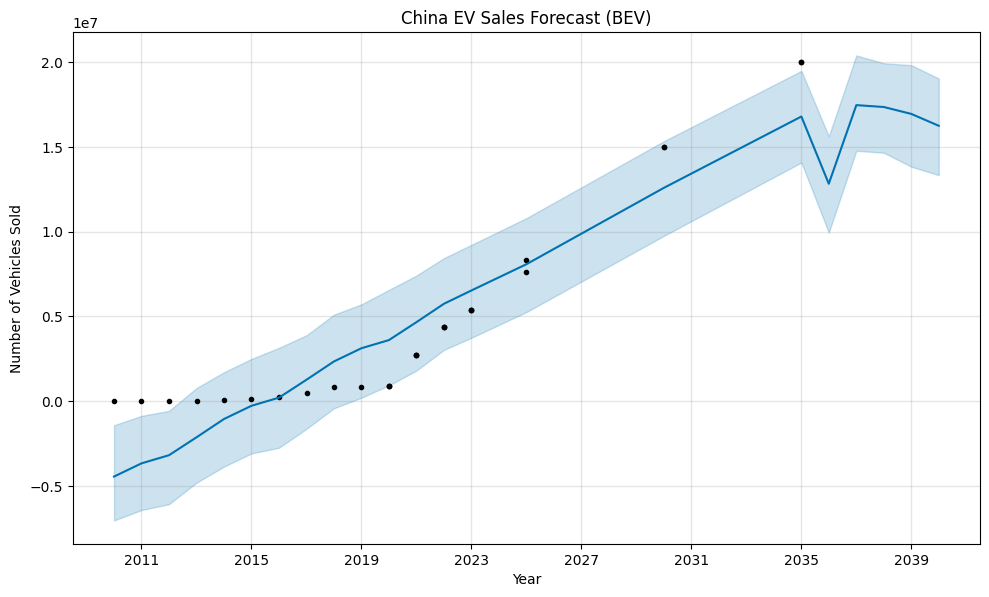

In [24]:
fig = model.plot(forecast)
plt.title('China EV Sales Forecast (BEV)')
plt.xlabel('Year')
plt.ylabel('Number of Vehicles Sold')
plt.show()

In [25]:
#Insight: "The forecast shows the model’s prediction of continued growth in BEV sales in China for the next five years, highlighting sustained adoption and market expansion.

In [26]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
12,2022-01-01,5.747767e+06,3.027571e+06,8.438185e+06
13,2023-01-01,6.532634e+06,3.742457e+06,9.222453e+06
14,2025-01-01,8.081323e+06,5.260194e+06,1.080050e+07
15,2030-01-01,1.258513e+07,9.754420e+06,1.533782e+07
16,2035-01-01,1.678937e+07,1.407921e+07,1.948054e+07
17,2035-12-31,1.282483e+07,9.944183e+06,1.562563e+07
18,2036-12-31,1.746218e+07,1.477217e+07,2.039359e+07
19,2037-12-31,1.735140e+07,1.465296e+07,1.993167e+07
20,2038-12-31,1.694453e+07,1.383265e+07,1.982010e+07
21,2039-12-31,1.624374e+07,1.333240e+07,1.903169e+07


In [27]:
#Insight: "Here are the forecasted sales values with confidence intervals, showing expected growth and possible variability.

In [28]:
# Splitting data into training and test sets (e.g., train on 2010–2021, test on 2022–2024)
train_data = china_sales_prophet[china_sales_prophet['ds'].dt.year <= 2021]
test_data = china_sales_prophet[china_sales_prophet['ds'].dt.year > 2021]

In [ ]:
model = Prophet(yearly_seasonality=True)
model.fit(train_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpckld7axi/x_ai81xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpckld7axi/64nq7nek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38113', 'data', 'file=/tmp/tmpckld7axi/x_ai81xq.json', 'init=/tmp/tmpckld7axi/64nq7nek.json', 'output', 'file=/tmp/tmpckld7axi/prophet_modelwtkulyqj/prophet_model-20250614155208.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:52:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [29]:
future_test = model.make_future_dataframe(periods=3, freq='Y')
forecast_test = model.predict(future_test)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [30]:
mae = mean_absolute_error(test_data['y'], forecast_test['yhat'][-len(test_data):])
rmse = np.sqrt(mean_squared_error(test_data['y'], forecast_test['yhat'][-len(test_data):]))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 1687857.8000682474
Root Mean Squared Error: 2008256.4786793608


In [ ]:
#Insight: "Model evaluation metrics indicate how well the model fits the historical data and helps assess the reliability of its forecast.

In [31]:
from statsmodels.tsa.arima.model import ARIMA

In [32]:
arima_model = ARIMA(train_data['y'], order=(5,1,0))
arima_fitted = arima_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

In [33]:
arima_forecast = arima_fitted.forecast(steps=3)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [34]:
train_data = china_sales_prophet[china_sales_prophet['ds'].dt.year <= 2021]
test_data = china_sales_prophet[china_sales_prophet['ds'].dt.year > 2021]

In [35]:
print(f"Shape of train_data: {train_data.shape}")
print(f"Shape of test_data: {test_data.shape}")

model = Prophet(yearly_seasonality=True)
model.fit(train_data)

future_test = model.make_future_dataframe(periods=3, freq='Y')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw9_wzj0/tv4i4cnm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw9_wzj0/cf0usdv7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58480', 'data', 'file=/tmp/tmplw9_wzj0/tv4i4cnm.json', 'init=/tmp/tmplw9_wzj0/cf0usdv7.json', 'output', 'file=/tmp/tmplw9_wzj0/prophet_modelm5hr9pa3/prophet_model-20250615073830.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:38:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Shape of train_data: (16, 2)
Shape of test_data: (12, 2)


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [36]:
forecast_test = model.predict(future_test)

In [37]:
print(f"Length of test data: {len(test_data)}")
print(f"Length of forecast data: {len(forecast_test)}")

Length of test data: 12
Length of forecast data: 15


In [38]:
forecast_test_slice = forecast_test[-len(test_data):]

In [39]:
# Printing lengths of test_data and forecast_test
print(f"Length of test_data: {len(test_data)}")
print(f"Length of forecast_test: {len(forecast_test)}")


Length of test_data: 12
Length of forecast_test: 15


In [40]:
# Making sure the forecast period is equal to the test data length
future_test = model.make_future_dataframe(periods=len(test_data), freq='Y')
forecast_test = model.predict(future_test)
print(f"Forecast length: {len(forecast_test)}")  # Should match the length of test_data

Forecast length: 24


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [41]:
# Printing lengths to understand the issue better
print(f"Length of test_data: {len(test_data)}")
print(f"Length of forecast_test_slice: {len(forecast_test_slice)}")

Length of test_data: 12
Length of forecast_test_slice: 12


In [42]:
# Making sure the forecast period matches the test data length
future_test = model.make_future_dataframe(periods=len(test_data), freq='Y')
forecast_test = model.predict(future_test)
# Printing forecast length and ensure it matches test data length
print(f"Length of forecast_test: {len(forecast_test)}")

Length of forecast_test: 24


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [43]:
# Adjusting the forecast to match the test data length
forecast_test_slice = forecast_test[-len(test_data):]  # Ensuring that the forecast has the same length as the test data
# Checking the length after slicing
print(f"Length of forecast_test_slice: {len(forecast_test_slice)}")

Length of forecast_test_slice: 12


In [44]:
print(forecast_test_slice.columns)  # Checking columns to confirm 'yhat' exists

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [45]:
# Now calculating the error metrics
mae = mean_absolute_error(test_data['y'], forecast_test_slice['yhat'])
rmse = np.sqrt(mean_squared_error(test_data['y'], forecast_test_slice['yhat']))
# Printing the error metrics
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 7735659.207431983
RMSE: 9349944.687189018


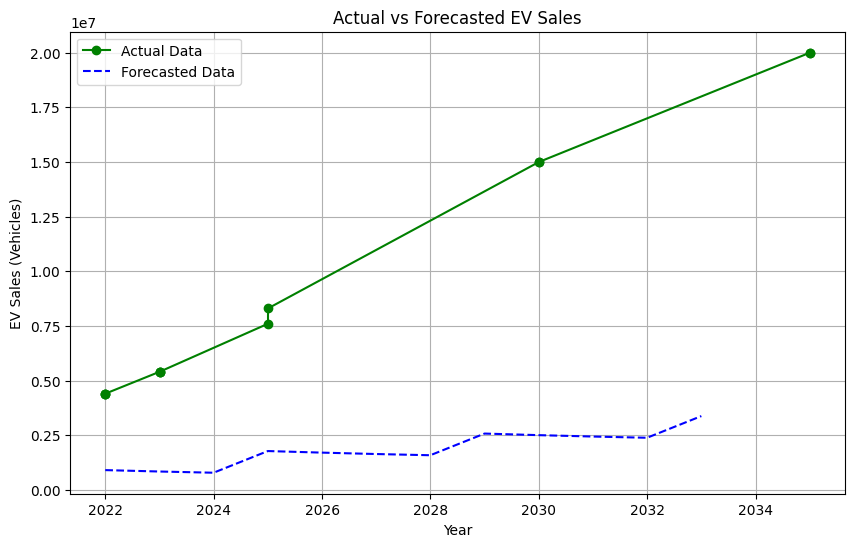

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual Data', color='green', marker='o')
plt.plot(forecast_test_slice['ds'], forecast_test_slice['yhat'], label='Forecasted Data', color='blue', linestyle='--')
plt.legend()
plt.title('Actual vs Forecasted EV Sales')
plt.xlabel('Year')
plt.ylabel('EV Sales (Vehicles)')
plt.grid(True)
plt.show()

In [47]:
from prophet.diagnostics import cross_validation, performance_metrics
# Performing cross-validation (here we use a 365-day horizon for evaluation)
cv_results = cross_validation(model, horizon='365 days')
# Evaluating the model performance (this will give metrics like MAE, RMSE, MAPE)
metrics = performance_metrics(cv_results)
# Showing performance metrics
print(metrics)

INFO:prophet:Making 15 forecasts with cutoffs between 2013-01-03 00:00:00 and 2020-01-02 00:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw9_wzj0/m0ytrsmn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw9_wzj0/kp9n19ui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11093', 'data', 'file=/tmp/tmplw9_wzj0/m0ytrsmn.json', 'init=/tmp/tmplw9_wzj0/kp9n19ui.json', 'output', 'file=/tmp/tmplw9_wzj0/prophet_model2gmkd3m_/prophet_model-20250615073853.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:38:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw9_wzj0/xzjlz24v.json
DEBUG:cmdstanpy:input tempfile

            horizon           mse          rmse           mae      mape  \
0 180 days 12:00:00  8.419224e+09  9.175633e+04  8.340615e+04  0.582975   
1 181 days 12:00:00  6.188140e+10  2.487597e+05  2.237391e+05  0.308641   
2 363 days 00:00:00  8.419224e+09  9.175633e+04  8.340615e+04  0.582975   
3 364 days 00:00:00  6.188140e+10  2.487597e+05  2.237391e+05  0.308641   
4 365 days 00:00:00  3.034692e+12  1.742037e+06  1.742037e+06  0.645199   

      mdape     smape  coverage  
0  0.612653  0.835701       0.0  
1  0.199304  0.400767       0.5  
2  0.612653  0.835701       0.0  
3  0.199304  0.400767       0.5  
4  0.645199  0.952463       0.0  


In [48]:
# Creating dummy external subsidy data (for testing)
external_subsidy_data = pd.DataFrame({
    'year': range(2010, 2025),  # From 2010 to 2024
    'subsidy': [1000, 1200, 1300, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
                2200, 2300, 2400, 2500, 2600]  # Sample subsidy values
})

# Check the data
external_subsidy_data.head()


,year,subsidy
0,2010,1000
1,2011,1200
2,2012,1300
3,2013,1500
4,2014,1600


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw9_wzj0/1ti00_o8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw9_wzj0/vb853kdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59844', 'data', 'file=/tmp/tmplw9_wzj0/1ti00_o8.json', 'init=/tmp/tmplw9_wzj0/vb853kdi.json', 'output', 'file=/tmp/tmplw9_wzj0/prophet_modelz_8mvn23/prophet_model-20250615073902.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:39:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:

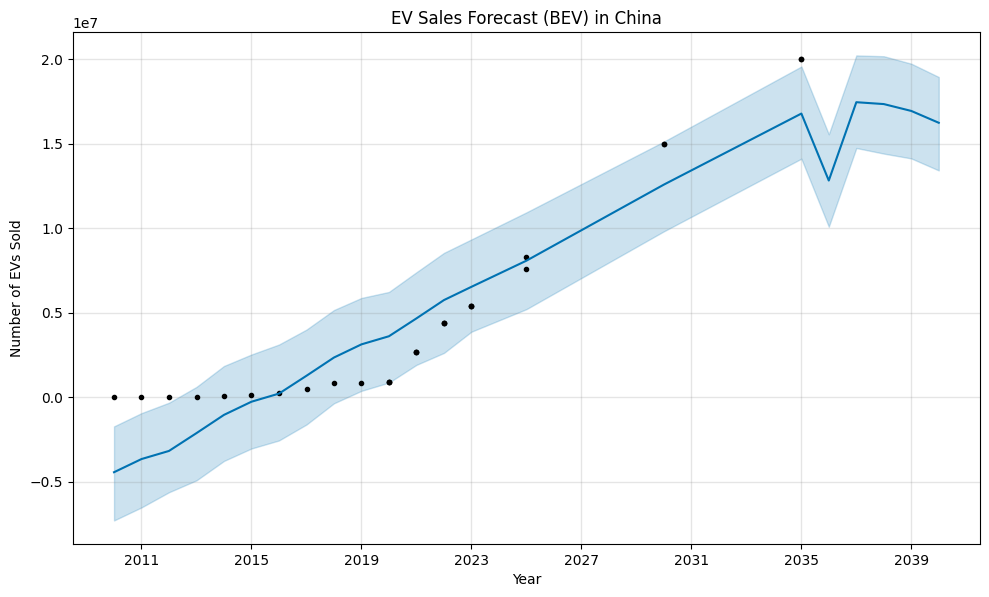

In [49]:
# Preparing the dataset for Prophet (ensure 'ds' is a datetime object)
china_sales_prophet = china_ev_sales[['year', 'value']].rename(columns={'year': 'ds', 'value': 'y'})
china_sales_prophet['ds'] = pd.to_datetime(china_sales_prophet['ds'], format='%Y')
# Initializing the Prophet model
model = Prophet(yearly_seasonality=True)
# Fitting the model
model.fit(china_sales_prophet)
# Generating future dataframe for the next 5 years
# Passing the model object 'model' as the first argument
future = model.make_future_dataframe(periods=5, freq='Y') # Added freq='Y' based on previous usage for consistency
# Generating the forecast
forecast = model.predict(future)
# Plotting the forecast
model.plot(forecast)
plt.title('EV Sales Forecast (BEV) in China')
plt.xlabel('Year')
plt.ylabel('Number of EVs Sold')
plt.show()

In [50]:
import plotly.express as px
fig = px.line(forecast, x='ds', y='yhat', title="EV Sales Forecast in China")
fig.show()

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Ensuring that the forecast is only for the test data period
forecast_test_slice = forecast_test[-len(test_data):]
# calculating the MAE and RMSE using the test data and the forecasted values
mae = mean_absolute_error(test_data['y'], forecast_test_slice['yhat'])
rmse = np.sqrt(mean_squared_error(test_data['y'], forecast_test_slice['yhat']))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 7735659.207431983, RMSE: 9349944.687189018


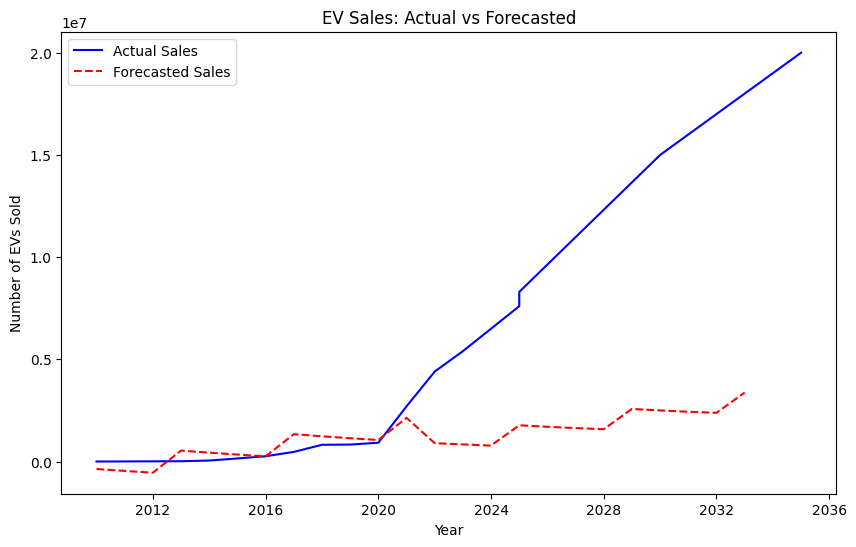

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(china_sales_prophet['ds'], china_sales_prophet['y'], label='Actual Sales', color='blue')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecasted Sales', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Number of EVs Sold')
plt.title('EV Sales: Actual vs Forecasted')
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import r2_score
r2 = r2_score(test_data['y'], forecast_test_slice['yhat'])
print(f"R²: {r2}")

R²: -1.5316979935571053


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



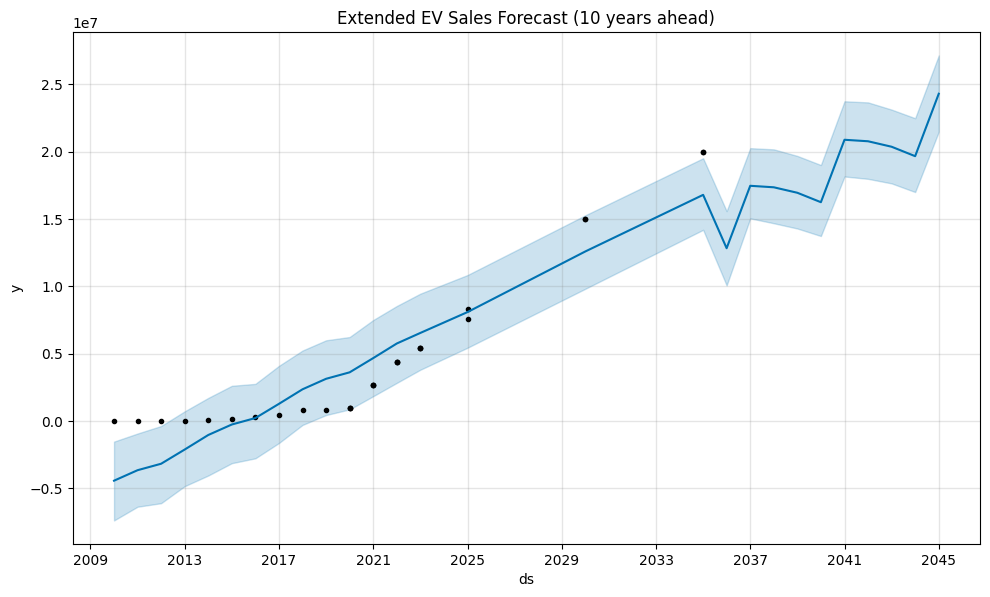

In [54]:
# Generate future dataframe for the next 10 years (no need to pass 'china_sales_prophet' twice)
future_extended = model.make_future_dataframe(periods=10, freq='Y')  # 10 more years
# Generate the forecast
forecast_extended = model.predict(future_extended)
# Plot the forecast
model.plot(forecast_extended)
plt.title('Extended EV Sales Forecast (10 years ahead)')
plt.show()